<a href="https://colab.research.google.com/github/garrettfarley9/Machine-Learning-Final-Project--Farley-Garrett-/blob/main/Farley_ML_Project_part_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from yellowbrick.regressor import ResidualsPlot
from google.colab import files
files.upload()

{}

#Data

In [52]:
bdf = pd.read_csv('SeoulBikeData.csv', encoding = 'unicode_escape')
bdf.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


###Aggregrated columns

In [53]:
'''
Model was not improved by representing dates in this way
bdf['Year'] = bdf['Date'].apply(lambda x : x[6:10])
bdf['Month'] = bdf['Date'].apply(lambda x : x[:2])
bdf['Day'] = bdf['Date'].apply(lambda x : x[3:5])
'''

#Aggregrate column
bdf['Hour avg'] = bdf.groupby(['Hour'])['Rented Bike Count'].transform('mean')
bdf['Season avg'] = bdf.groupby(['Seasons'])['Rented Bike Count'].transform('mean')


#EDA Plots

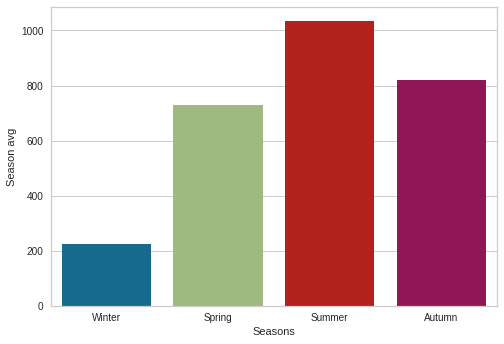

In [54]:
plot = sns.barplot(data = bdf, x = 'Seasons', y = 'Season avg')

This plot shows aggregated seasonal average of bike rental volume by season.

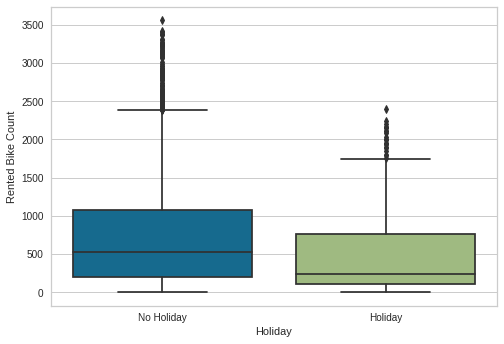

In [55]:
plot = sns.boxplot(data = bdf, x = 'Holiday', y = 'Rented Bike Count')

This plot shows the number of rented bikes on Holiday vs No Holiday

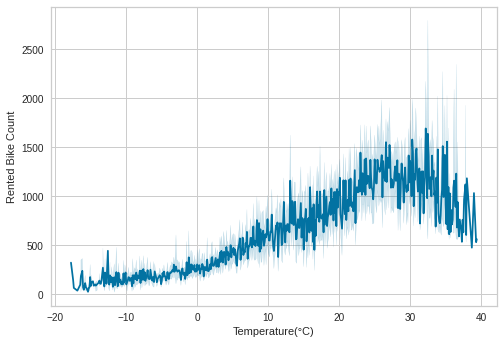

In [56]:
plot = sns.lineplot(data = bdf, x= 'Temperature(°C)', y = 'Rented Bike Count')

This plot shows the rented bike count as a function of temperature.

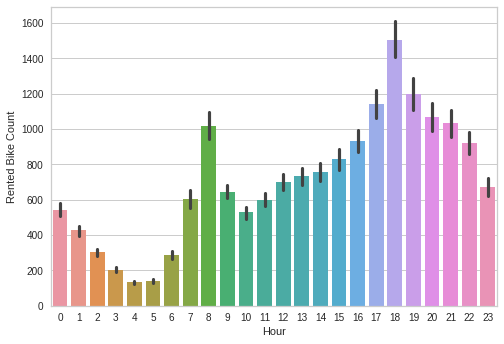

In [57]:
plot = sns.barplot(data = bdf, x = 'Hour', y = 'Rented Bike Count')

This plot shows the rented bike count as a function of time in the day.

#Analysis

There are some relationships between features and the rented bike count that I can use to predict the volume of bike rentals in a given hour. The time of day matters and we even see two spikes where people are going to work, and coming from work. We even see that in the plot of Holidays vs Non-Holidays where holidays don't see as many rentals. There is a seasonal relationship that is likely connected to the temperature more than anything. It seems that the temperature outside matters a lot when people consider a bike ride and the warmer it gets, the more variable the data gets. The other features were really noisy when compared to bike rental numbers or they were corelated to another variable, e.g. humidity and dew point with temperature.

#Preprocessing Data

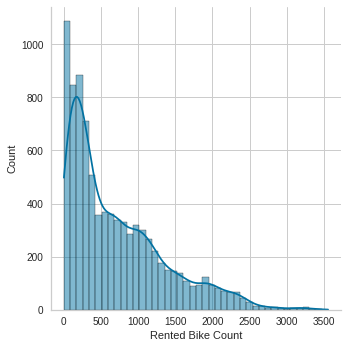

In [58]:
plot = sns.displot(bdf, x = 'Rented Bike Count', kde = True)

###Imputation
There are no values that need to be imputed.

In [59]:
bdf.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
Hour avg                     0
Season avg                   0
dtype: int64

###Encoding features
Holiday were encoded with Label encoding and Seasons were OneHot encoded. Other binary encoding of atmospheric data split on the mean will hopefully improve the model's fit.

In [60]:


le = LabelEncoder()
bdf['Holiday'] = le.fit_transform(bdf['Holiday'])
bdf['Functioning Day'] = le.fit_transform(bdf['Holiday'])

temp = pd.get_dummies(bdf, columns = ['Seasons'])
temp = temp.filter(regex = 'Seasons_\w+')
bdf = pd.concat([bdf, temp], axis = 1)
bdf = bdf.drop(columns = ['Seasons'])

bdf['Visibility_bin']=bdf['Visibility (10m)'].apply(lambda x: 1 if x>=2000 else 0)
bdf['Rainfall_bin']=bdf['Rainfall(mm)'].apply(lambda x:1 if x>=0.148687 else 0)
bdf['Snowfall_bin']=bdf['Snowfall (cm)'].apply(lambda x:1 if x>=0.075068 else 0)
bdf['Solar Radiation_bin']=bdf['Solar Radiation (MJ/m2)'].apply(lambda x:1 if x>=0.56911 else 0)


#Fitting the Models

###Assign data and fit models
Data was assigned to test or train data then passed through the linear regression model and the stochastic gradient descent regression model.


In [61]:

y_data = bdf['Rented Bike Count']
x_data = bdf.drop(columns = ['Rented Bike Count', 'Date'])

#Scale data
scaler = StandardScaler()
x_data = scaler.fit_transform(x_data)

#Assign test and train data
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.10, random_state = 4200)

#Initialize regression model object
lin_reg = linear_model.LinearRegression()
sgd_reg = linear_model.SGDRegressor()

#Train models
lin_reg = lin_reg.fit(x_train, y_train)
sgd_reg = sgd_reg.fit(x_train, y_train)




###Accuracy and residual plots
The accuracy and plots of residuals.

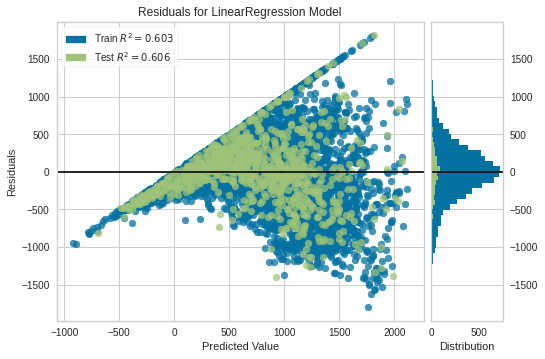

In [62]:
#Check accuracy of linear regression model
lin_reg.predict(x_test)
lin_reg.score(x_test, y_test)

viz = ResidualsPlot(lin_reg)
viz.fit(x_train,y_train)
viz.score(x_test, y_test)
viz.show()

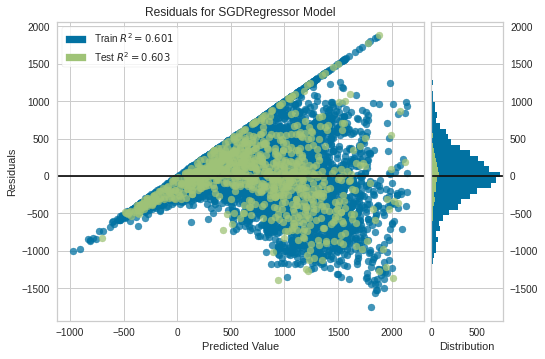

In [63]:
#Check accuracy of SGD regression model
sgd_reg.predict(x_test)
sgd_reg.score(x_test, y_test)

viz = ResidualsPlot(sgd_reg)
viz.fit(x_train,y_train)
viz.score(x_test, y_test)
viz.show()

###Fitting linear regression model with less training data

Test size: 0.2


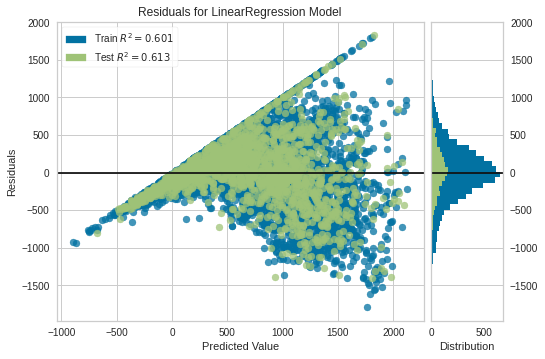

Test size: 0.3


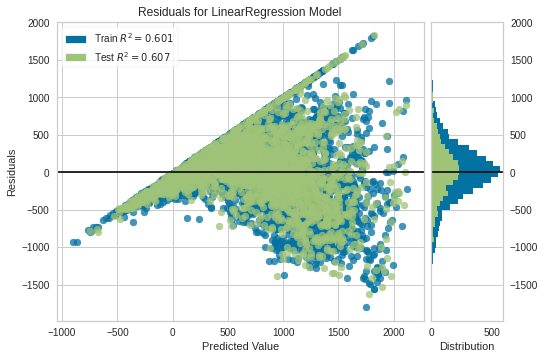

Test size: 0.5


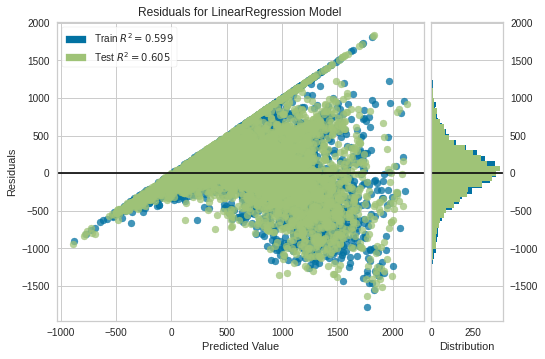

Test size: 0.7


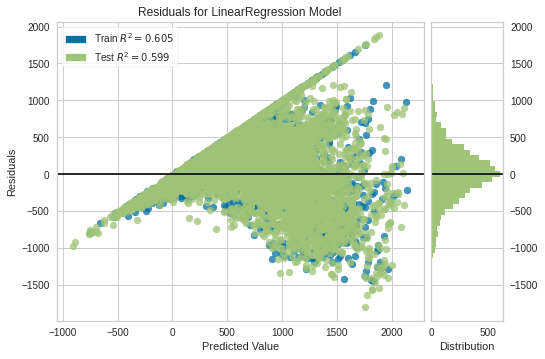

Test size: 0.8


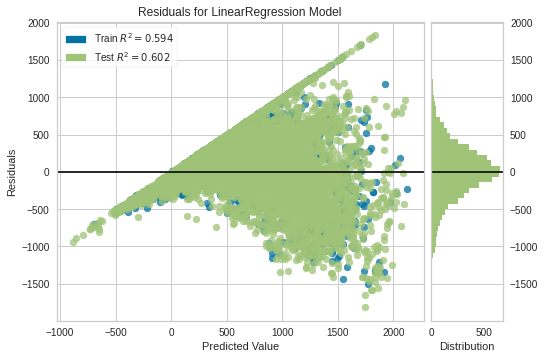

Test size: 0.9


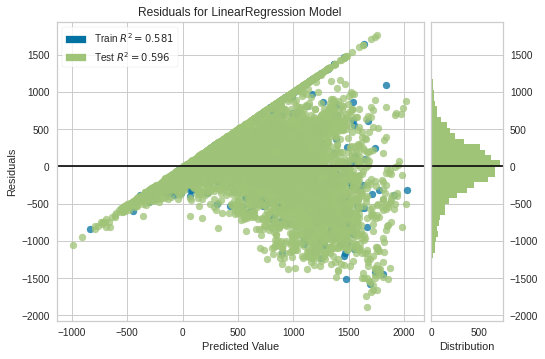

In [64]:
p = [0.2, 0.3, 0.5, 0.7, 0.8, 0.9]

for i in p:
  x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = i, random_state = 4200)
  lin_reg = linear_model.LinearRegression()
  lin_reg = lin_reg.fit(x_train, y_train)

  viz = ResidualsPlot(lin_reg)
  viz.fit(x_train,y_train)
  viz.score(x_test, y_test)
  print("Test size:", i)
  viz.show()




#Final Analysis
The aggregrated columns included the binning of rainfall, snowfall, and solar radiation based on the mean into a binary--1 above the mean and 0 below. The visibility feature was set at 2000m binary--1 if it equaled 2000 and 0 if not. To a model, the differences in visibility matter a lot, but to humans, a slight change in visibility matters less. 

The linear regression (60.5%) and the stochastic gradient descent (60.1%)models performed about the same in this problem with this dataset. The linear regression did a bit better (61.3% accuracy at best), and you can see how the performance doesn't really change much as you change the proportions of train-to-test data. It did get worse as you trained on less data, which is to be expected. You can see from the residuals plot that the model begins by overshooting the actual vaues. That variation that we saw in the hour and temperature graphs from hours 16-22 and the temperature range between 30-40 degrees probably contributed to the loss in accuracy here.

I wonder if, by binning the atmospheric data, we created a better environment for a decision tree model? That might be an area to explore in further work on this problem.